# Análisis de Sentimientos en Reseñas de Amazon
## 1. Introducción

Este notebook tiene como finalidad realizar un análisis de sentimientos sobre reseñas de productos de Amazon.
Se utilizarán técnicas de Procesamiento de Lenguaje Natural (PLN) para preprocesar los textos y analizar la polaridad de los sentimientos.

## 2. Instalación y Configuración

En este punto importamos las librerias que usaremos en este análisis incluidos los Modelos NLP.
A continuacion descargamos los recursos adicionales necesarios

In [1]:

# Instalación de las librerías necesarias
!pip install pandas numpy nltk spacy textblob scikit-learn matplotlib seaborn imblearn vaderSentiment wordcloud

# Importación de librerías
import pandas as pd
from datetime import datetime, timedelta
from time import strftime
import re
import nltk
import spacy
import os
import time
import csv
import pickle
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

spacy.cli.download('en_core_web_sm')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE # SMOTE
from collections import Counter

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
#SOLO PARA CARGAR DATOS EN GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
## variables y funciones no analiticas

hora_ejecucion_analisis = strftime("%Y-%m-%d_%H-%M-%S")
lreviews_path = "/content/drive/MyDrive/Colab Notebooks/Datos/All_Beauty.jsonl"
lmetadata_path = "/content/drive/MyDrive/Colab Notebooks/Datos/meta_All_Beauty.jsonl"
output_statistics = f"/content/drive/MyDrive/Colab Notebooks/Datos/tiempos_ejecuciones_TFM_{hora_ejecucion_analisis}.csv"
BI_output_metadata = f"/content/drive/MyDrive/Colab Notebooks/Datos/sentiment_analysis_metadata_formatted_{hora_ejecucion_analisis}.csv"
BI_output_review = f"/content/drive/MyDrive/Colab Notebooks/Datos/sentiment_analysis_review_formatted_{hora_ejecucion_analisis}.csv"
output_pickle=f"/content/drive/MyDrive/Colab Notebooks/Datos/best_model_and_vectorizer_{hora_ejecucion_analisis}.pkl"
print(hora_ejecucion_analisis)

def registrar_tiempo(bloque, output_statistics, inicio=None):
    """
    Registra tiempos de inicio y fin de un bloque.

    :param bloque: Nombre del bloque
    :param output_statistics: Ruta del archivo CSV
    :param inicio: `None` para inicio del bloque, o `float` para tiempo inicial
    :return: Tiempo de inicio si inicio es `None`
    """
    current_time = time.time()
    readable_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(current_time))

    if inicio is None:
        # Inicio del bloque
        print(f"Iniciando {bloque} a las {readable_time}")
        return current_time
    else:
        # Fin del bloque
        print(f"Bloque {bloque} finalizado a las {readable_time}")
        duration_seconds = current_time - inicio

        if duration_seconds < 60:
            duration = f"{duration_seconds:.2f} segundos"
        else:
            duration_minutes = duration_seconds / 60
            duration = f"{duration_minutes:.2f} minutos"

        print(f"Duración: {duration}")

        with open(output_statistics, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                bloque,
                time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(inicio)),
                readable_time,
                duration
            ])

2025-01-08_21-27-37


## 3. Carga y Limpieza de Datos

Cargaremos los datos elegidos, en este caso usare la info de All_Beauty, tanto reviews como metadata en dataframes de pandas.
Por ahora solo usaremos reviews para este TFM.

In [4]:
# Iniciar el registro del tiempo
bloque = 'CargaDatos'
inicio = registrar_tiempo(bloque, output_statistics)


# Funciones para cargar y limpiar datos
def load_data(reviews_path, metadata_path):
    if not os.path.exists(reviews_path) or not os.path.exists(metadata_path):
        raise FileNotFoundError("Uno o ambos archivos no se encontraron.")
    reviews = pd.read_json(reviews_path, lines=True)
    metadata = pd.read_json(metadata_path, lines=True)
    return reviews, metadata

# Cargar los datos
reviews_path = lreviews_path
metadata_path = lmetadata_path

reviews_df, metadata_df = load_data(reviews_path, metadata_path)

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando CargaDatos a las 2025-01-08 21:27:44
Bloque CargaDatos finalizado a las 2025-01-08 21:28:08
Duración: 23.92 segundos


## 3.1 Eliminación de Nulos y duplicados

En este paso trataremos los valores nulos y eliminar duplicados



In [5]:
# Iniciar el registro del tiempo
bloque = 'Eliminaciondenulosyduplicados'
inicio = registrar_tiempo(bloque, output_statistics)


# Revisaremos valores nulos
# Se verifica cuántos valores faltan en cada columna para identificar problemas en los datos.
print(reviews_df.isnull().sum())

# Buscaremos duplicados basados en parametros que nos indicarian que una cuenta ha dado mas reseñas y puntuacion sobre un producto
duplicates = reviews_df[reviews_df.duplicated(subset=['title','text', 'rating', 'asin', 'user_id'])]

# Mostrar el conteo de duplicados
print(f"Número de duplicados basados en 'title','text', 'rating', 'asin', 'user_id': {len(duplicates)}")

# Mostramos las filas duplicadas
# print(duplicates.head(10))

# Eliminaremos los duplicados para inspección y confirmar la data filtrada
reviews_df = reviews_df.drop_duplicates(subset=['title', 'text', 'rating', 'asin', 'user_id'])

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando Eliminaciondenulosyduplicados a las 2025-01-08 21:28:17
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
Número de duplicados basados en 'title','text', 'rating', 'asin', 'user_id': 7276
Bloque Eliminaciondenulosyduplicados finalizado a las 2025-01-08 21:28:22
Duración: 5.39 segundos


## 4. Exploración de Datos (EDA)

Iniciando EDA a las 2025-01-08 21:28:36
<class 'pandas.core.frame.DataFrame'>
Index: 694252 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             694252 non-null  int64         
 1   title              694252 non-null  object        
 2   text               694252 non-null  object        
 3   images             694252 non-null  object        
 4   asin               694252 non-null  object        
 5   parent_asin        694252 non-null  object        
 6   user_id            694252 non-null  object        
 7   timestamp          694252 non-null  datetime64[ns]
 8   helpful_vote       694252 non-null  int64         
 9   verified_purchase  694252 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 53.6+ MB
None
              rating                      timestamp   helpful_vote
count  694252.000000           

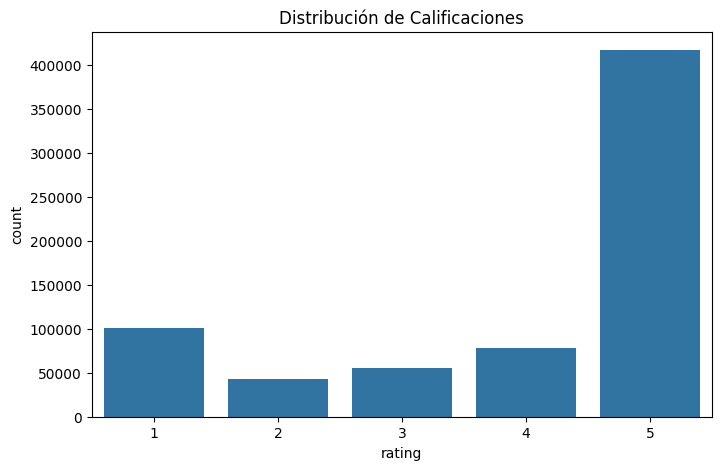

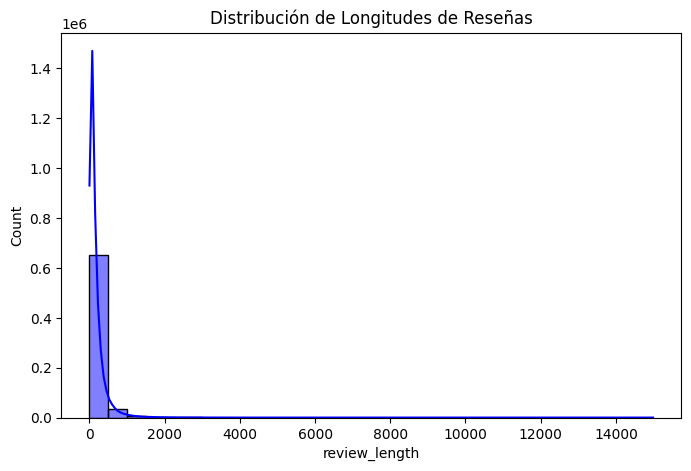

Bloque EDA finalizado a las 2025-01-08 21:28:41
Duración: 5.10 segundos


In [6]:
# Iniciar el registro del tiempo
bloque = 'EDA'
inicio = registrar_tiempo(bloque, output_statistics)

# Exploración básica de los datos

print(reviews_df.info())
print(reviews_df.describe())

# Visualización de la distribución de calificaciones
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=reviews_df)
plt.title("Distribución de Calificaciones")
plt.show()

# Análisis de la longitud de las reseñas
reviews_df['review_length'] = reviews_df['text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(reviews_df['review_length'], bins=30, kde=True, color='blue')
plt.title("Distribución de Longitudes de Reseñas")
plt.show()

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)


## 5. Procesamiento de Lenguaje Natural

## 5.1 Preprocesamiento de Textos

Análisis de presencia de emoticonos y signos de puntuación para luego eliminarlos, convertiremos todos los caracteres del campo "text" a minúscula.

In [7]:
# Iniciar el registro del tiempo
bloque = 'PLN-Preprocesamientodetexto'
inicio = registrar_tiempo(bloque, output_statistics)

# Definimos el patrón para emoticonos (básicos y emojis)
emoticon_pattern = r"[\:\;\=][\-\^]?[\(\)\[\]\{\}\@D\|Pp\$\*\+\#]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F]"

# Identificamos emoticonos

# Pasamos a crear las columnas que indiquen si hay emoticonos en 'text' y 'title'
reviews_df['con_emoticonText'] = reviews_df['text'].apply(lambda x: bool(re.search(emoticon_pattern, x)))

# # Mostrar los valores únicos y su frecuencia
# print("Valores únicos en 'con_emoticonText':", reviews_df['con_emoticonText'].unique())
# print("Frecuencia en 'con_emoticonText':\n", reviews_df['con_emoticonText'].value_counts())

# Mostramos ejemplos de texto con emoticonos
# Extraer ejemplos de textos y títulos que contienen emoticonos

# examples_text_with_emoticons = reviews_df[reviews_df['con_emoticonText'] == True][['text']].head(5)

# print("\nEjemplos de textos con emoticonos:")
# print(examples_text_with_emoticons)

# Eliminamos los emoticonos
# Función para eliminar emoticonos
def remove_emoticons(text):
    if isinstance(text, str):  # Verificar si es texto
        return re.sub(emoticon_pattern, '', text)
    return text  # Devolver el valor original si no es texto

# Lo aplicamos la limpieza sobre 'text' y 'title'
reviews_df['text_noemoji'] = reviews_df['text'].apply(remove_emoticons)

# print("\nEjemplo después de eliminar emoticonos:")
# print(reviews_df[['text', 'text_noemoji']].head(5))

# Eliminamos los signos de puntuación y saltos de línea en 'text'
reviews_df['text_limpio'] = reviews_df['text_noemoji'].str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n|\r', ' ', regex=True)

# print("\nEjemplo después de eliminar signos de puntuación y saltos de línea:")
# print(reviews_df[['text', 'text_limpio']].head(5))

# Convertimos los caracteres a min en el campo 'text_limpio'
reviews_df['text_limpio'] = reviews_df['text_limpio'].str.lower()

#print("\nEjemplo después de convertir los caracteres a minuscula:")
#print(reviews_df[['text', 'text_limpio']].head(5))


# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando PLN-Preprocesamientodetexto a las 2025-01-08 21:28:51
Bloque PLN-Preprocesamientodetexto finalizado a las 2025-01-08 21:29:06
Duración: 15.14 segundos


## 5.2 StopWords y Lematizador

En este punto aplicaremos los distintos procedimientos como: Tokenización, eliminación de stop words y lematización.
* En el proceso de Tokenización lo que se hace es la conversión de frases en una secuencia de palabras separadas, a los cuales denominaremos tokens.
* En el proceso de Eliminación de Stop Words es necesario ya que el conjunto de datos en bruto contiene algunos dialectos o palabras que aportan significado durante la conversación, pero que tienen poco o ningún significado cuando se procesan.
* En el proceso de Lematización se usa para reducir cualquier palabra a su palabra raíz. Este proceso asigna diferentes palabras del diccionario a su conjunto cognitivo, por ejemplo 'was', 'are', 'is' sera reducido a ‘be’.

In [8]:
# Iniciar el registro del tiempo
bloque = 'StopWords-Lematizador'
inicio = registrar_tiempo(bloque, output_statistics)

#Cargamos el diccionario de StopWords en ingles, debido a que nuestras reviews estan en este idioma.
stop_words = set(stopwords.words('english'))
#Cargamos el modulo de lematización
lemmatizer = WordNetLemmatizer()
#Se aplicara sobre el campo text_limpio, que es el campo que ha sido preprocesado.
def preprocess_text(text_limpio):
    tokens = word_tokenize(text_limpio)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

#Se dejara este texto procesado sobre una nueva columna llamada "clean_text"
reviews_df['clean_text'] = reviews_df['text_limpio'].apply(preprocess_text)

#Mostraremos un vistazo a la columna previa "text_limpio" y post procesada "clean_text".
# print("\nEjemplo del campo 'clean_text' post aplicacion de Tokenizacion, Stopwords y Lematizacion")
# print(reviews_df[['text_limpio', 'clean_text']].head(5))

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando StopWords-Lematizador a las 2025-01-08 21:29:17
Bloque StopWords-Lematizador finalizado a las 2025-01-08 21:32:13
Duración: 2.93 minutos


## 6. Análisis de Sentimientos

### 6.1 Análisis de Sentimientos con el modelo preentrenado VADER

In [9]:
# Iniciar el registro del tiempo
bloque = 'AnalisisSentimientosVADER'
inicio = registrar_tiempo(bloque, output_statistics)

# Análisis de sentimientos con VADER
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        sentiment = 'POSITIVE'
    elif compound <= -0.05:
        sentiment = 'NEGATIVE'
    else:
        sentiment = 'NEUTRAL'
    return compound, sentiment

# Aplicar la función y asignar resultados a dos columnas
reviews_df[['sentiment_v', 'sentiment_v_literal']] = reviews_df['clean_text'].apply(
    lambda x: pd.Series(vader_sentiment(x))
)

# Mostrar una vista previa de los resultados
# print(reviews_df[['clean_text', 'sentiment_v', 'sentiment_v_literal']].head(50))

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando AnalisisSentimientosVADER a las 2025-01-08 21:32:27
Bloque AnalisisSentimientosVADER finalizado a las 2025-01-08 21:35:55
Duración: 3.47 minutos


## 7. Visualización de Resultados

Utilizaremos las librerías de visualización descargadas al inicio, como matplotlib y seaborn para visualizar los resultados.

Iniciando VisualizacionResultados a las 2025-01-08 21:36:07


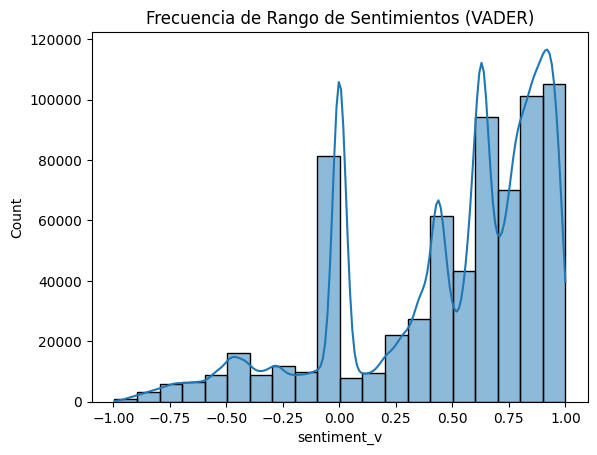

\Conteo de Sentimientos:
sentiment_v_literal
POSITIVE    538534
NEUTRAL      79821
NEGATIVE     75897
Name: count, dtype: int64


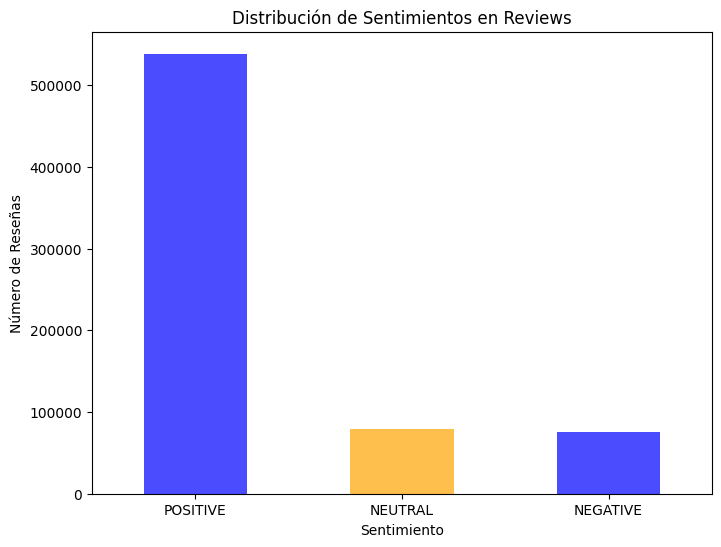

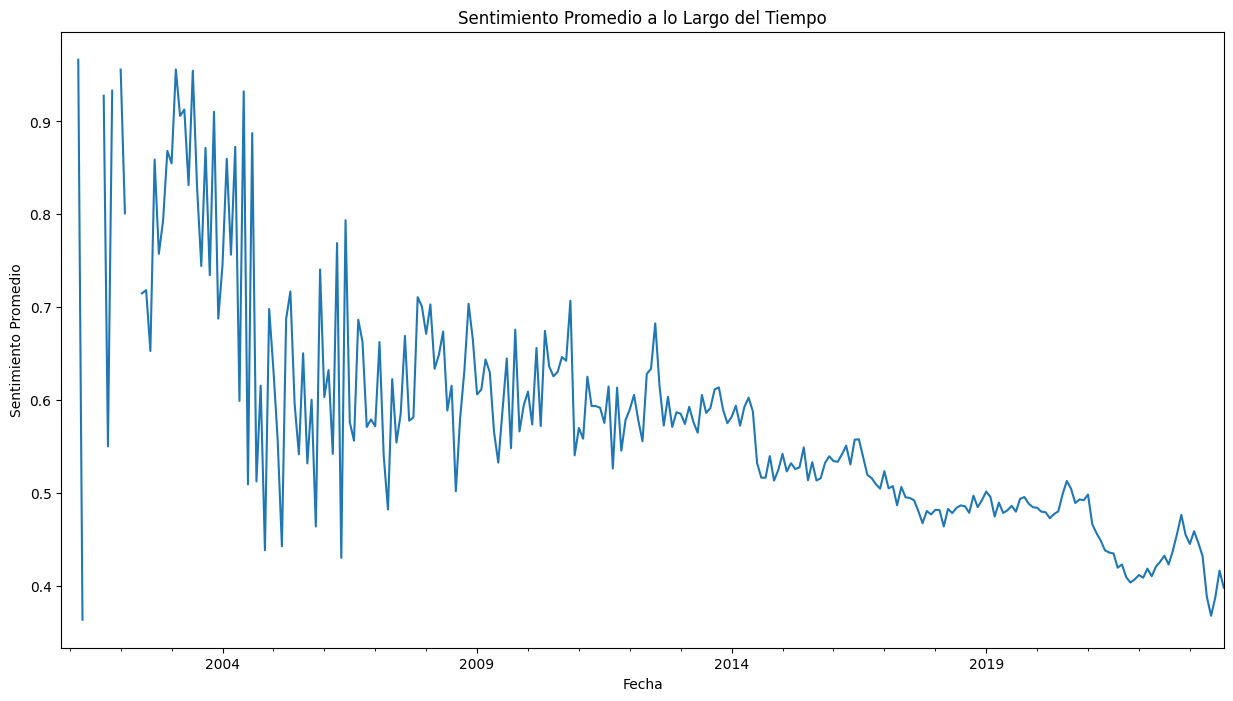

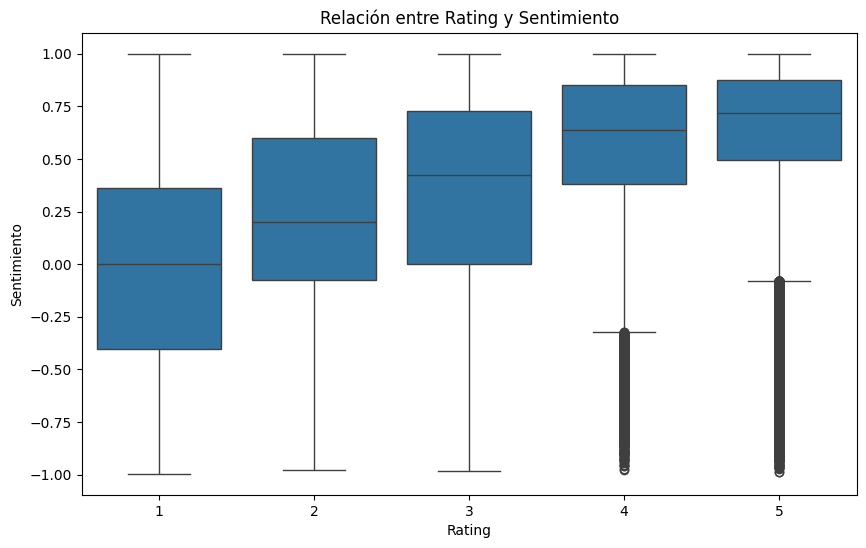

Bloque VisualizacionResultados finalizado a las 2025-01-08 21:36:12
Duración: 5.27 segundos


In [10]:
# Iniciar el registro del tiempo
bloque = 'VisualizacionResultados'
inicio = registrar_tiempo(bloque, output_statistics)

sns.histplot(reviews_df['sentiment_v'], bins=20, kde=True)
plt.title('Frecuencia de Rango de Sentimientos (VADER)')
plt.show()

# Visualización de la distribución de sentimientos
# Revisaremos el conteo de la distribución de sentimientos
sentiment_counts = reviews_df['sentiment_v_literal'].value_counts()
print("\Conteo de Sentimientos:")
print(sentiment_counts)


# Visualizaremos la distribución de sentimientos
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title("Distribución de Sentimientos en Reviews")
plt.xlabel("Sentimiento")
plt.ylabel("Número de Reseñas")
plt.xticks(rotation=0)
plt.show()

# Análisis de los datos temporales (timestamp)
# Convertiremos el timestamp a una fecha legible y analizaremos las tendencias temporales.
reviews_df['date'] = pd.to_datetime(reviews_df['timestamp'], unit='ms')
reviews_df.set_index('date', inplace=True)
# Resamplear solo la columna 'sentiment_tb'
sentiment_over_time = reviews_df['sentiment_v'].resample('ME').mean()
# Graficar los resultados
plt.figure(figsize=(15, 8))
sentiment_over_time.plot()
plt.title('Sentimiento Promedio a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Sentimiento Promedio')
plt.show()

#Analizamos la relacion entre Rating y Sentimiento (VADER)
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='sentiment_v', data=reviews_df)
plt.title('Relación entre Rating y Sentimiento')
plt.xlabel('Rating')
plt.ylabel('Sentimiento')
plt.show()

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)


## 7.1 Visualizaciones graficas asociadas a tokens

Iniciando Visualizaciontokens a las 2025-01-08 21:36:22


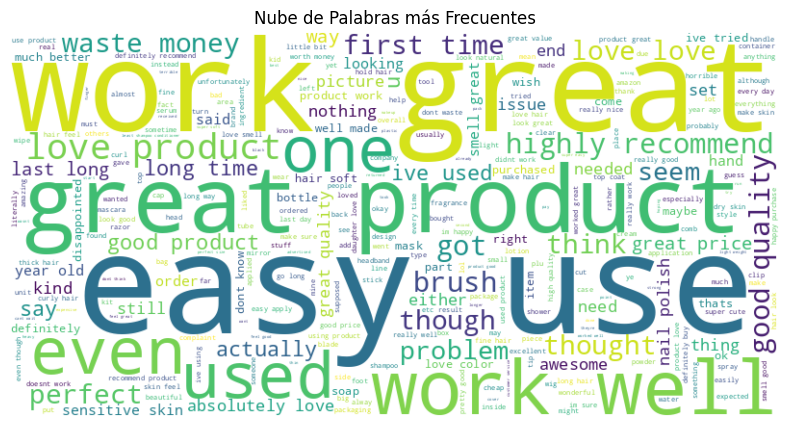

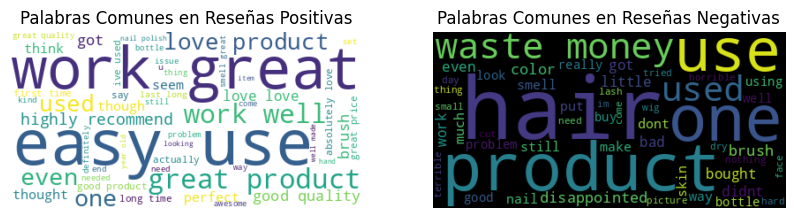

Bloque Visualizaciontokens finalizado a las 2025-01-08 21:38:21
Duración: 1.99 minutos


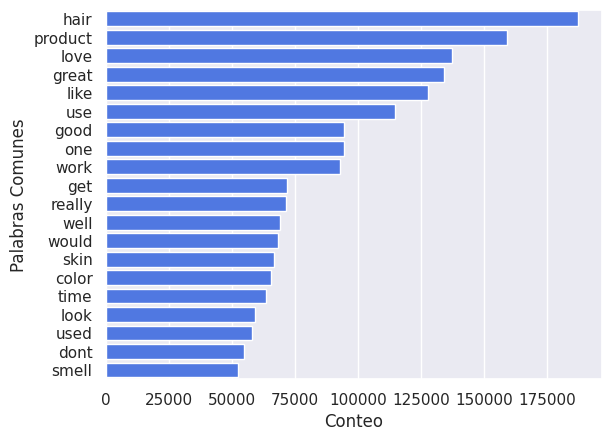

In [11]:
# Iniciar el registro del tiempo
bloque = 'Visualizaciontokens'
inicio = registrar_tiempo(bloque, output_statistics)

# WordCloud de Tokens en general
wordcloud = WordCloud(max_words=300, background_color='white', width=800, height=400).generate(' '.join(reviews_df['clean_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras más Frecuentes")
plt.show()

# WordCloud de Tokens de Reseñas Positivas y Negativas
positive_reviews = ' '.join(reviews_df[reviews_df['sentiment_v'] >= 0]['clean_text'])
negative_reviews = ' '.join(reviews_df[reviews_df['sentiment_v'] < 0]['clean_text'])
wordcloud_positive = WordCloud(max_words=50, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(max_words=50, background_color='black').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Palabras Comunes en Reseñas Positivas')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Palabras Comunes en Reseñas Negativas')
plt.axis('off')
plt.show()

# Numero de tokens que aparecen con mas frecuencia
reviews_df['temp_list'] = reviews_df['clean_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in reviews_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Palabras Comunes','Conteo']
temp.style.background_gradient(cmap='Blues')

sns.set_theme(palette='rainbow')
sns.barplot(x="Conteo", y="Palabras Comunes", data=temp)

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

## 7.2 Conversion de sentimientos en etiquetas a numeros

Creemos que convertirlas a formato numérico puede ser más eficiente y práctico, especialmente cuando trabajas con bibliotecas de aprendizaje automático como scikit-learn, que suelen esperar etiquetas numéricas para los modelos de clasificación.

In [12]:
# Iniciar el registro del tiempo
bloque = 'ConvertiretiquetasAnumeros'
inicio = registrar_tiempo(bloque, output_statistics)

# Mapear etiquetas textuales a valores numéricos
sentiment_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
reviews_df['sentiment_numeric'] = reviews_df['sentiment_v_literal'].map(sentiment_mapping)

# Verificar la distribución
print(reviews_df['sentiment_numeric'].value_counts())

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando ConvertiretiquetasAnumeros a las 2025-01-08 21:38:30
sentiment_numeric
2    538534
1     79821
0     75897
Name: count, dtype: int64
Bloque ConvertiretiquetasAnumeros finalizado a las 2025-01-08 21:38:30
Duración: 0.03 segundos


## 7.3 Exportamos datos para luego aplicar Inteligencia de Negocios

In [13]:
print(metadata_df.info())
print(reviews_df.info())

# Mostrar las primeras 20 filas del DataFrame metadata_df
print(metadata_df.head(20).to_string())

# Mostrar las primeras 20 filas del DataFrame reviews_df
print(reviews_df.head(20).to_string())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112590 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101259 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       float64
dtypes: float64(3), int64(1), object(10)
memory usage: 12.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 694252 entries,

In [14]:
# Iniciar el registro del tiempo
bloque = 'ExportarDatos_BI_CSV'
inicio = registrar_tiempo(bloque, output_statistics)

# Creamos DataFrames temporales con las columnas elegidas para analizar en PowerBI
temp_metadata_df = metadata_df[['main_category','title', 'average_rating', 'rating_number', 'price', 'images', 'store', 'parent_asin']].copy()
temp_reviews_df = reviews_df[['timestamp','rating', 'title', 'parent_asin', 'user_id', 'helpful_vote', 'review_length', 'clean_text', 'sentiment_v', 'sentiment_v_literal', 'sentiment_numeric']].copy()

# Reemplazamos el punto (.) por coma (,) en las columnas correspondientes
average_price = temp_metadata_df['price'].mean()
temp_metadata_df['price'] = temp_metadata_df['price'].fillna(average_price)
temp_metadata_df['price'] = temp_metadata_df['price'].apply(lambda x: str(x).replace('.', ',') if not pd.isna(x) else x)
temp_metadata_df['average_rating'] = temp_metadata_df['average_rating'].apply(lambda x: str(x).replace('.', ',') if not pd.isna(x) else x)
temp_reviews_df['sentiment_v'] = temp_reviews_df['sentiment_v'].apply(lambda x: str(x).replace('.', ','))


# Exportamos los DataFrames temporales a CSV
temp_metadata_df.to_csv(
    BI_output_metadata,
    index=False,
    sep=';',  # Usamos punto y coma como separador
)

temp_reviews_df.to_csv(
    BI_output_review,
    index=False,
    sep=';',  # Usamos punto y coma como separador
)

print("Datos exportados")

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando ExportarDatos_BI_CSV a las 2025-01-08 21:38:46
Datos exportados
Bloque ExportarDatos_BI_CSV finalizado a las 2025-01-08 21:39:02
Duración: 15.54 segundos


# 8 Implementación de los Modelos de Machine Learning

Durante el procesado de los datos, hemos visto que la distribucion de los sentimientos no esta balanceada, por lo que hemos decidido procesar este escenario primero y luego otro en el que forzaremos balancear la data usando la libreria SMOTE, de manera que podamos para analizar las diferencias en los posibles resultados, tendremos en cuenta lo siguiente:

* Compararemos el rendimiento de los modelos con y sin SMOTE.
* Esperamos mejoras en la clasificación de clases minoritarias (NEUTRAL, NEGATIVE) con el conjunto balanceado.
* Usaremos métricas como F1-Score ponderado para evaluar el modelo, especialmente en casos de datos desbalanceados.
* Consideraremos la generaración de gráficos para comparar la precisión (Accuracy) y F1-Score de los modelos con y sin SMOTE

## 8.1 Modelos con clases desbalanceadas

### 8.1.1 Preparación de los datos

In [15]:
# Iniciar el registro del tiempo
bloque = 'MML-ClasesDesbalanceadas'
inicio = registrar_tiempo(bloque, output_statistics)

# # Vectorización con menos características
# vectorizer = TfidfVectorizer(max_features=5000)
# X = vectorizer.fit_transform(reviews_df['clean_text'])
# y = reviews_df['sentiment_numeric']

# # Dividir datos
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Inicializar un DataFrame para almacenar los resultados
# results = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Duration (s)"])

# # Función para calcular y almacenar métricas
# def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_df):
#     start_time = time.time()
#     print(f"\n{name} - Start Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     end_time = time.time()
#     duration = end_time - start_time
#     print(f"{name} - End Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))
#     print(f"{name} - Duration:", duration, "seconds")
#     accuracy = accuracy_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred, average='weighted')
#     print("Accuracy:", accuracy)
#     print("F1 Score:", f1)
#     print(classification_report(y_test, y_pred))

#     # Crear un nuevo DataFrame para esta ejecución
#     new_result = pd.DataFrame(
#         {"Model": [name], "Accuracy": [accuracy], "F1 Score": [f1], "Duration (s)": [duration]}
#     )
#     # Concatenar resultados al DataFrame existente
#     results_df = pd.concat([results_df, new_result], ignore_index=True)

#     return results_df, model, y_pred


# # Evaluar modelos
# results, lsvc, lsvc_y_pred = evaluate_model("Linear SVC", LinearSVC(), X_train, y_train, X_test, y_test, results)
# results, nb, nb_y_pred = evaluate_model("Multinomial Naive Bayes", MultinomialNB(), X_train, y_train, X_test, y_test, results)
# results, rf, rf_y_pred = evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, n_jobs=-1), X_train, y_train, X_test, y_test, results)
# results, lr, lr_y_pred = evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test, results)

# # Mostrar resultados en una tabla
# print("\nComparación de Modelos:")
# print(results)

# # Graficar Curvas ROC
# def plot_roc_curve(model, X_test, y_test, label):
#     y_pred_prob = model.predict_proba(X_test)
#     fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values.ravel(), y_pred_prob.ravel())
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

# plt.figure(figsize=(10, 8))
# plot_roc_curve(nb, X_test, y_test, "Naive Bayes")
# plot_roc_curve(rf, X_test, y_test, "Random Forest")
# plot_roc_curve(lr, X_test, y_test, "Logistic Regression")
# # Nota: LinearSVC no soporta predict_proba directamente, se omite aquí
# plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
# plt.title("Curvas ROC")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend(loc="lower right")
# plt.show()

# # Matriz de confusión del mejor modelo
# conf_mat = confusion_matrix(y_test, lr_y_pred)
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
# plt.title("Matriz de Confusión - Logistic Regression")
# plt.xlabel("Predicción")
# plt.ylabel("Real")
# plt.show()


# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando MML-ClasesDesbalanceadas a las 2025-01-08 21:39:19
Bloque MML-ClasesDesbalanceadas finalizado a las 2025-01-08 21:39:19
Duración: 0.00 segundos


## 8.2 Modelos con clases balanceadas

### 8.2.1 Preparación de los datos

In [16]:
# Iniciar el registro del tiempo
bloque = 'MML-ClasesBalanceadas'
inicio = registrar_tiempo(bloque, output_statistics)

# # Vectorización con menos características
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(reviews_df['clean_text'])
y = reviews_df['sentiment_numeric']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Paso 1: Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar balanceo
print("Distribución de clases después de SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Crear DataFrame para resultados
results_smote = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score", "Duration (s)"])

# Función para evaluar un modelo con SMOTE
def evaluate_model_smote(name, model, X_train, y_train, X_test, y_test, results_df):
    import time
    start_time = time.time()
    print(f"\n{name} (SMOTE) - Start Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    duration = end_time - start_time
    print(f"{name} (SMOTE) - End Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))
    print(f"{name} (SMOTE) - Duration:", duration, "seconds")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))

    # Crear un nuevo DataFrame para esta ejecución
    new_result = pd.DataFrame(
        {"Model": [name], "Accuracy": [accuracy], "F1 Score": [f1], "Duration (s)": [duration]}
    )
    # Concatenar resultados al DataFrame existente
    results_df = pd.concat([results_df, new_result], ignore_index=True)

    return results_df, model, y_pred

# Evaluar modelos con SMOTE
# results_smote, lsvc_smote, lsvc_y_pred_smote = evaluate_model_smote(
#     "Linear SVC", LinearSVC(), X_train_smote, y_train_smote, X_test, y_test, results_smote
# )
# results_smote, nb_smote, nb_y_pred_smote = evaluate_model_smote(
#     "Multinomial Naive Bayes", MultinomialNB(), X_train_smote, y_train_smote, X_test, y_test, results_smote
# )
# results_smote, rf_smote, rf_y_pred_smote = evaluate_model_smote(
#     "Random Forest", RandomForestClassifier(n_estimators=100, n_jobs=-1),
#     X_train_smote, y_train_smote, X_test, y_test, results_smote
# )
results_smote, lr_smote, lr_y_pred_smote = evaluate_model_smote(
    "Logistic Regression", LogisticRegression(max_iter=1000),
    X_train_smote, y_train_smote, X_test, y_test, results_smote
)

# Mostrar resultados en una tabla
print("\nResultados balanceados (SMOTE):")
print(results_smote)

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando MML-ClasesBalanceadas a las 2025-01-08 21:39:26
Distribución de clases después de SMOTE:
sentiment_numeric
2    430827
1    430827
0    430827
Name: count, dtype: int64

Logistic Regression (SMOTE) - Start Time: 2025-01-08 21:43:06
Logistic Regression (SMOTE) - End Time: 2025-01-08 21:43:56
Logistic Regression (SMOTE) - Duration: 50.37157130241394 seconds
Accuracy: 0.9182721046301431
F1 Score: 0.9214518968304313
              precision    recall  f1-score   support

           0       0.67      0.82      0.74     15180
           1       0.83      0.90      0.87     15964
           2       0.98      0.93      0.96    107707

    accuracy                           0.92    138851
   macro avg       0.83      0.89      0.85    138851
weighted avg       0.93      0.92      0.92    138851


Resultados balanceados (SMOTE):
                 Model  Accuracy  F1 Score  Duration (s)
0  Logistic Regression  0.918272  0.921452     50.371571
Bloque MML-ClasesBalanceadas finalizado a las 

<ipython-input-16-d374efbfd0a4>:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_result], ignore_index=True)


## 9. Conclusiones

### Conclusiones parciales clases desbalanceadas

Basándome en los resultados y los gráficos obtenidos, estas son las conclusiones del análisis de los modelos entrenados con clases desbalanceadas:

1. Comparación de Modelos
Mejor rendimiento: Los modelos Linear SVC y Logistic Regression mostraron una precisión (Accuracy) muy similar, ambos alrededor del 94%, con valores de F1-Score superiores a 0.94. Esto los posiciona como los modelos más efectivos para este conjunto de datos.
Random Forest también logró una precisión competitiva (~92.8%) y un F1-Score de 0.92, pero su tiempo de ejecución es significativamente mayor (2150 segundos frente a ~17 segundos para Linear SVC y Logistic Regression).
Multinomial Naive Bayes tiene el menor rendimiento con un F1-Score de 0.76 y precisión de 81.3%, debido a su menor capacidad para manejar datos desbalanceados.
2. Curvas ROC
Las curvas ROC muestran que los modelos Random Forest y Logistic Regression tienen un desempeño superior, con un AUC cercano a 0.99, lo que significa que tienen una excelente capacidad de clasificación.
El modelo Naive Bayes, aunque tiene un AUC de 0.96, es menos robusto que los otros modelos.
3. Matriz de Confusión
La matriz de confusión para Logistic Regression indica:
Clase 2 (POSITIVE): Es la mejor predicha, con más de 105,000 instancias correctamente clasificadas y muy pocas mal clasificadas.
Clase 0 (NEGATIVE): Presenta mayor confusión con las otras clases, especialmente con la clase POSITIVE.
Clase 1 (NEUTRAL): Se predice razonablemente bien, pero tiene cierta confusión con las otras clases.
4. Implicaciones del Desbalanceo
La mayoría de las instancias pertenecen a la clase POSITIVE, lo que favorece que los modelos sean más precisos para esta clase.
Las clases NEGATIVE y NEUTRAL tienen menor representación, lo que genera más confusión y afecta la capacidad del modelo para clasificar estas instancias correctamente.
5. Conclusiones
Para datos desbalanceados, Logistic Regression y Linear SVC son las mejores opciones debido a su precisión, F1-Score y rapidez.
Aunque Random Forest tiene un buen desempeño, su costo computacional lo hace menos atractivo para escenarios grandes como este.
Naive Bayes no es adecuado para este problema debido al desbalance de clases.
Recomendaciones:
Implementar SMOTE o técnicas de re-muestreo para balancear las clases y evaluar si el desempeño mejora, especialmente para las clases minoritarias (NEGATIVE y NEUTRAL).
Enfocarse en métricas como F1-Score y AUC para evaluar el impacto del balanceo en las predicciones.


### Conclusiones clases balanceadas

1. Impacto del Balanceo de Clases (SMOTE): La aplicación de SMOTE equilibró las clases en el dataset, lo que resultó en una mejora notable en el rendimiento de los modelos, especialmente para las clases minoritarias (NEGATIVE y NEUTRAL).
Aunque el balanceo incrementa la equidad en la clasificación, puede aumentar el riesgo de overfitting en modelos más complejos como Random Forest.

2. Mejores Modelos: Linear SVC y Logistic Regression se destacaron como las opciones más balanceadas entre precisión (91.9% y 91.8%, respectivamente), F1-Score (~92.2%) y velocidad de ejecución (~50-78 segundos).
Random Forest fue el modelo más preciso (92.7% de precisión y F1-Score), pero su tiempo de entrenamiento fue considerablemente alto (~2 horas). Es ideal para escenarios donde los recursos computacionales no son una limitación.
Multinomial Naive Bayes mostró un rendimiento aceptable (83.4% de precisión) con una velocidad extremadamente rápida (0.38 segundos). Es una buena opción para escenarios donde el tiempo de procesamiento es crítico.

3. Desempeño en Clases: Todos los modelos mejoraron significativamente en la identificación de las clases minoritarias (NEGATIVE y NEUTRAL) después del balanceo.
Los modelos aún muestran una ligera dificultad para la clase NEGATIVE en comparación con POSITIVE y NEUTRAL.


Iniciando MML-LinearRegression-BestParameters a las 2025-01-08 21:49:44
Mejores Hiperparámetros: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-Score Macro: 0.8968010613712476
Informe de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     15180
           1       0.83      0.90      0.87     15964
           2       0.98      0.94      0.96    107707

    accuracy                           0.92    138851
   macro avg       0.83      0.89      0.86    138851
weighted avg       0.93      0.92      0.92    138851



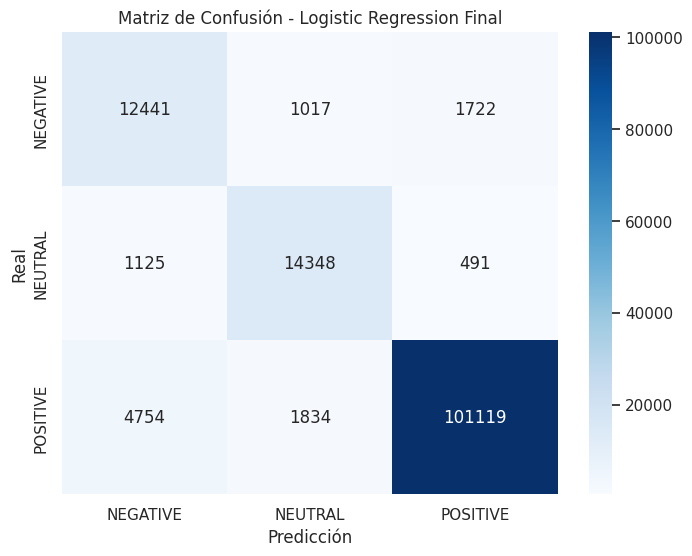

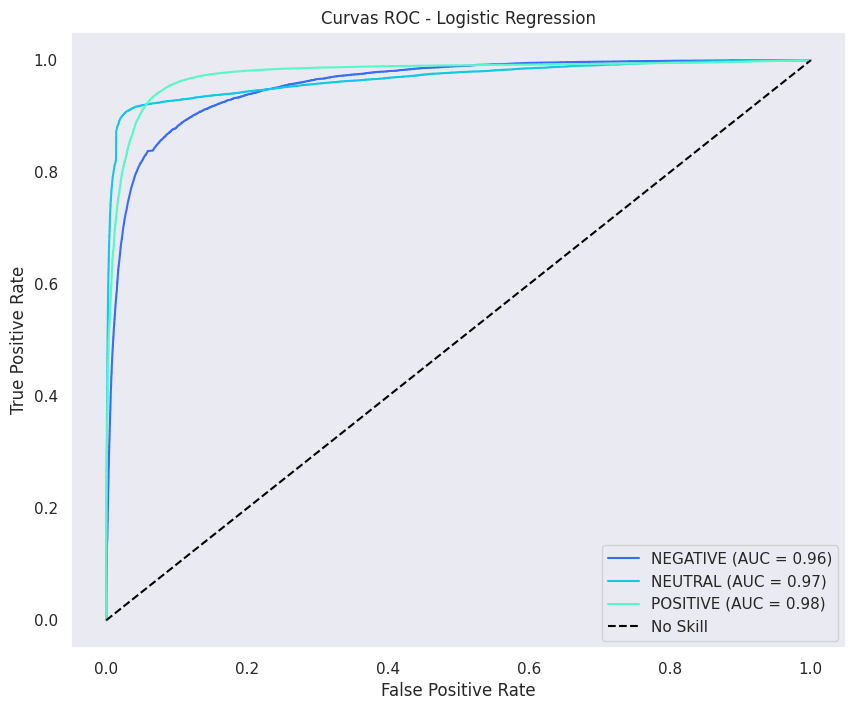

Modelo Logistic Regression guardado en 'logistic_regression_model.pkl'
Bloque MML-LinearRegression-BestParameters finalizado a las 2025-01-08 22:02:16
Duración: 12.53 minutos


In [17]:
# Iniciar el registro del tiempo
bloque = 'MML-LinearRegression-BestParameters'
inicio = registrar_tiempo(bloque, output_statistics)
# Definir el modelo base
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Definir los hiperparámetros a optimizar
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularización
    'solver': ['liblinear'],  # Algoritmo de optimización
    'penalty': ['l2'],  # Penalización
}

# Definir el scoring con F1-Score Macro para priorizar clases minoritarias
scorer = make_scorer(f1_score, average='macro')

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # Validación cruzada con 5 particiones
    n_jobs=4,  # Limitar a 4 hilos para reducir el uso del CPU
)

# Ajustar GridSearchCV al conjunto de datos balanceados
grid_search.fit(X_train_smote, y_train_smote)

# Mostrar los mejores hiperparámetros y el mejor puntaje
print("Mejores Hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score Macro:", grid_search.best_score_)

# Entrenar el modelo final con los mejores hiperparámetros
best_log_regL = grid_search.best_estimator_
best_log_regL.fit(X_train_smote, y_train_smote)

#BORRABLE

# Predicciones en el conjunto de prueba
y_pred_test = best_log_regL.predict(X_test)

# Informe de clasificación
print("Informe de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'], yticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
plt.title("Matriz de Confusión - Logistic Regression Final")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


# Obtener las predicciones probabilísticas del modelo
y_pred_proba = best_log_regL.predict_proba(X_test)

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i, label in enumerate(['NEGATIVE', 'NEUTRAL', 'POSITIVE']):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

# Línea base
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

# Configuración del gráfico
plt.title("Curvas ROC - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Guardar el modelo Logistic Regression
with open(output_pickle, 'wb') as f:
    pickle.dump({
        'model': best_log_regL,  # Modelo de Logistic Regression optimizado
        'vectorizer': vectorizer  # Vectorizador utilizado
    }, f)

print("Modelo Logistic Regression guardado en 'logistic_regression_model.pkl'")

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

In [ ]:
# # 1. Entrenar el modelo ganador -->Logistic Regression
# best_model = LogisticRegression(max_iter=1000, random_state=42)
# best_model.fit(X_train_smote, y_train_smote)

# # 2. Predecir sentimientos en el conjunto de prueba
# y_pred_test = best_model.predict(X_test)

# # 3. Evaluar el modelo
# print("Resultados del modelo en el conjunto de prueba:")
# print("Accuracy:", accuracy_score(y_test, y_pred_test))
# print(classification_report(y_test, y_pred_test))

# # 4. Matriz de confusión
# conf_mat = confusion_matrix(y_test, y_pred_test)
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
# plt.title("Matriz de Confusión - Mejor Modelo")
# plt.xlabel("Predicción")
# plt.ylabel("Real")
# plt.show()

# # 5. Prueba con nuevas reseñas
# new_reviews = [
#     "This product is amazing, it completely exceeded my expectations!",
#     "Horrible experience, the product broke after one use.",
#     "can be better"
# ]

# # Vectorizar las nuevas reseñas
# new_reviews_vectorized = vectorizer.transform(new_reviews)

# # Predecir sentimientos
# new_predictions = best_model.predict(new_reviews_vectorized)

# # Mapear las etiquetas numéricas a literales
# label_mapping = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
# new_predictions_labels = [label_mapping[label] for label in new_predictions]

# # Mostrar resultados
# for review, prediction in zip(new_reviews, new_predictions_labels):
#     print(f"Review: '{review}' --> Sentimiento: {prediction}")

In [18]:
# Iniciar el registro del tiempo
bloque = 'MML-LinearRegression-TestingModel'
inicio = registrar_tiempo(bloque, output_statistics)

# Reseñas de prueba
new_reviews = [
    "The product was fantastic! Exceeded my expectations.",
    "This is the worst product I’ve ever purchased. It broke immediately.",
    "Amazing quality, very durable and worth the price.",
    "Completely useless, it didn’t work as described.",
    "The product is great",
    "the quality is average",
    "It works as described, but I wouldn't buy it again."
]

# Función para cargar el modelo y realizar predicciones
def test_model(model_path, reviews):
    # Cargar el modelo y el vectorizador
    with open(model_path, 'rb') as f:
        data = pickle.load(f)
    model = data['model']
    vectorizer = data['vectorizer']

    # Vectorizar las nuevas reseñas
    reviews_vectorized = vectorizer.transform(reviews)

    # Predecir los sentimientos
    predictions = model.predict(reviews_vectorized)

    # Mapear etiquetas numéricas a literales
    label_mapping = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
    predictions_labels = [label_mapping[label] for label in predictions]

    return predictions_labels

# Probar con Logistic Regression
logistic_predictions = test_model(output_pickle, new_reviews)
print("Resultados Logistic Regression:")
for review, prediction in zip(new_reviews, logistic_predictions):
    print(f"Review: '{review}' --> Sentimiento: {prediction}")

# Finalizar el registro del tiempo
registrar_tiempo(bloque, output_statistics, inicio=inicio)

Iniciando MML-LinearRegression-TestingModel a las 2025-01-08 22:06:49
Resultados Logistic Regression:
Review: 'The product was fantastic! Exceeded my expectations.' --> Sentimiento: POSITIVE
Review: 'This is the worst product I’ve ever purchased. It broke immediately.' --> Sentimiento: NEGATIVE
Review: 'Amazing quality, very durable and worth the price.' --> Sentimiento: POSITIVE
Review: 'Completely useless, it didn’t work as described.' --> Sentimiento: NEGATIVE
Review: 'The product is great' --> Sentimiento: POSITIVE
Review: 'the quality is average' --> Sentimiento: NEUTRAL
Review: 'It works as described, but I wouldn't buy it again.' --> Sentimiento: NEUTRAL
Bloque MML-LinearRegression-TestingModel finalizado a las 2025-01-08 22:06:49
Duración: 0.01 segundos
